In [1]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
########################################### Funktionen #########################################################################################

def kinetic (circuit, dt, dx, m):       # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits
    N = 2**n
    dp = 2*np.pi/N/dx

    a = -dt/2*dp**2/m
    b = -np.pi/dp/n/dx

    for i in range(n):
        circuit.p(a*2*n*b*2**i, i)
        circuit.p(a*4**i, i)
        for j in range(i+1,n):
            circuit.cp(2*a*2**(i+j),j,i)


    return circuit


def potential (circuit, dt, dx, m, omega):      # Gates zur Simulation des quadratischen Potentials
    n = circuit.num_qubits
    N = 2**n 
    d = N*dx/2

    a = -dt/2*m*omega**2*dx**2
    b = -d/dx/n

    for i in range(n):
        circuit.p(a*2*n*b*2**i, i)
        circuit.p(a*4**i, i)
        for j in range(i+1,n):
            circuit.cp(2*a*2**(i+j),j,i)


def timeEv (circuit, q, dt, dx, m, omega, iterations):      # Zeitentwicklung
    n = circuit.num_qubits 
    for i in range(iterations):
        circuit.append(QFT(n), q[:])
        kinetic(circuit=circuit, dt=dt, dx=dx, m=m)
        circuit.append(QFT(n, inverse=True), q[:])
        potential(circuit=circuit, dt=dt, dx=dx, m=m, omega=omega)

    return circuit

In [3]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

dt = 0.001
m = 1
omega = 10000

# Ortsraumgitter
d = 3
dx= 2*d/N
x = np.arange(-d, d, dx)

# Gaußsches Wellenpaket als Anfangszustand
""" mu = x[36]
alpha = 1
psi=  (alpha/np.pi)**(1/4)* np.exp(-0.5*alpha*(x-mu)**2)
psi/= np.sqrt(np.sum(np.abs(psi**2))) """

# Delta-Funktion als Anfangszustand 
mu = x[36]
psi = np.array([0 if (i != mu) else 1 for i in x])

#plt.plot(x, psi)

In [10]:
########################################### Simulation Zustandsvektor ##########################################################################

q = QuantumRegister(n)      # Erzeugen eines Quantenregisters ohne ancilla-Qubit
circuit = QuantumCircuit(q) # Erstellen eiens circuits

#Initialisierung des Anfangszustandes
circuit.initialize(psi,q[:])

# Festlegen des Simulators, hier Zustandsvektor-Simulator
simulator = Aer.get_backend('statevector_simulator')

# Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird
evolution = []

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
evolution.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 70
rg = 9      # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit, q, dt, dx, m, omega=omega, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))        # Ausgabe der Normierungsüberprüfung um Fortschritt der Simulation sichtbar zu machen
    prob = statevector.probabilities()
    evolution.append(prob)

0:True
1:True
2:True
3:True
4:True
5:True
6:True
7:True
8:True


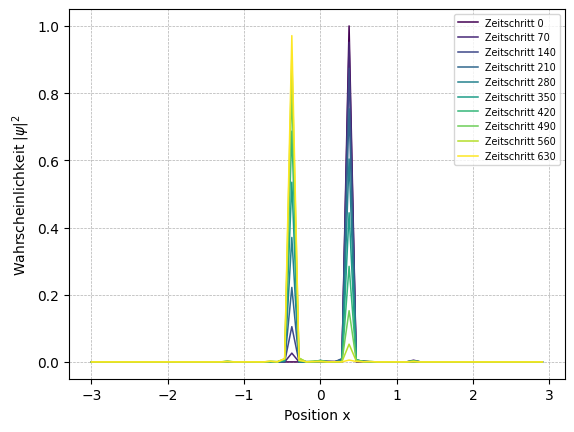

In [11]:
########################################### Plots ################################################################################################

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

for i in range(len(evolution)):
    plt.plot(x, evolution[i], color=colors[i], linewidth=1.1, label='Zeitschritt ' + str(i*it))

plt.xlabel('Position x')
plt.ylabel(r'Wahrscheinlichkeit $|\psi|^2$')
plt.legend(loc='upper right', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_quadratisches_pot.jpg', bbox_inches='tight', dpi=300)

In [12]:
########################################### mittlere Position ###############################################################################

# Bestimmung der mittleren Position pro gespeichertem Zeitschritt
mean_pos = []
for i in range(len(evolution)):
    temp = 0
    for j in range(N):
        temp = temp + j*evolution[i][j]
    mean_pos.append(-d+temp*dx)

# Anpassen eines Kosinus-Kurve an die Positionen
def cos (x, a, b, c):
    return a * np.cos(b*(x-c))
    
zeitschritte = it*np.arange(0,rg+1,1)

popt1, pcov1 = curve_fit(cos, zeitschritte, mean_pos, p0=[0.4, 0.003, 0])

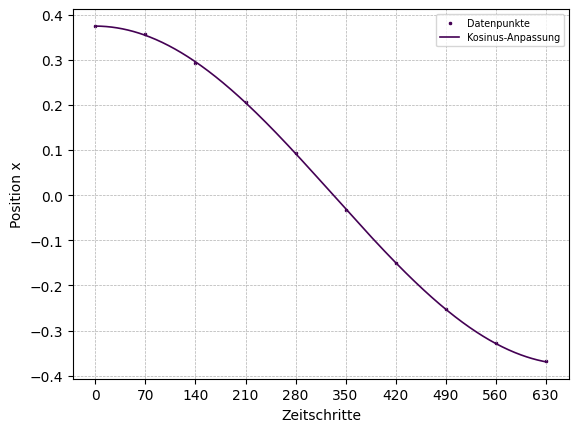

In [13]:
########################################### Plot ############################################################################################

x_werte = np.linspace(0, zeitschritte[-1]+1, 500)

plt.scatter(zeitschritte, mean_pos, s=3, marker='x', color=colors[0], label='Datenpunkte')
plt.plot(x_werte, cos(x_werte, popt1[0], popt1[1], popt1[2]), color=colors[0], linewidth=1.2, label='Kosinus-Anpassung')

plt.xticks(zeitschritte, zeitschritte)
plt.xlabel('Zeitschritte')
plt.ylabel('Position x')
plt.legend(loc = 'upper right', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_quadratisches_pot_schwingung.jpg', bbox_inches='tight', dpi=300)